In [4]:
from qiskit import QuantumRegister
import numpy as np
from gymnasium.spaces import Box
from rl_qoc import QuantumEnvironment, BenchmarkConfig
from qiskit.circuit import QuantumCircuit, ParameterVector, Gate
from qiskit.circuit.library import CZGate, RXGate, XGate
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ChannelRewardConfig,
)
from rl_qoc.qibo import QiboConfig
from gymnasium.wrappers import ClipAction


def param_circuit(
    qc: QuantumCircuit, params: ParameterVector, qreg: QuantumRegister, **kwargs
):
    target = kwargs["target"]
    gate: Gate = target["gate"]
    custom_gate = Gate(f"{gate.name}_cal", 2, params.params)
    qc.append(custom_gate, qreg)

    return qc


def get_backend():
    return "qibolab"


target = {"gate": CZGate(), "physical_qubits": [0, 1]}
instruction_durations = {}
action_space_low = np.array(
    [0.0, 16], dtype=np.float32
)  # [amp, phase, phase, duration]
action_space_high = np.array(
    [1.0, 160], dtype=np.float32
)  # [amp, phase, phase, duration]
action_space = Box(action_space_low, action_space_high)
qibo_config = QiboConfig(
    param_circuit,
    get_backend(),
    platform="dummy",
    qubit_pair=(0, 2),
    gate_rule="cz",
    parametrized_circuit_kwargs={"target": target},
    instruction_durations=None,
)
q_env_config = QEnvConfig(
    target={"gate": CZGate(), "physical_qubits": [0, 1]},
    backend_config=qibo_config,
    action_space=action_space,
    reward_config=ChannelRewardConfig(),
    benchmark_config=BenchmarkConfig(0),
    execution_config=ExecutionConfig(
        batch_size=1, sampling_paulis=50, n_shots=1000, n_reps=1
    ),
)

env = QuantumEnvironment(q_env_config)

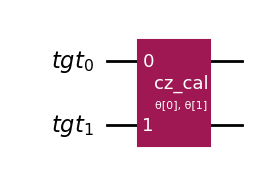

In [5]:
env.circuits[0].draw(output="mpl")

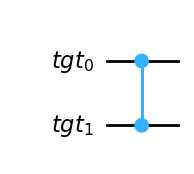

In [6]:
env.baseline_circuits[0].draw(output="mpl")

In [7]:
from rl_qoc import CustomPPO
from rl_qoc.agent import TrainFunctionSettings, TotalUpdates, TrainingConfig
from rl_qoc.helpers import load_from_yaml_file

file_name = "agent_config.yaml"

agent_config = load_from_yaml_file(file_name)

In [ ]:
ppo = CustomPPO(agent_config, ClipAction(env))
total_updates = TotalUpdates(500)
# hardware_runtime = HardwareRuntime(300)
training_config = TrainingConfig(
    training_constraint=total_updates,
    target_fidelities=[0.999, 0.9999],
    lookback_window=10,
    anneal_learning_rate=True,
    std_actions_eps=1e-2,
)

train_function_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=True,
    num_prints=1,
    hpo_mode=False,
    clear_history=True,
)

In [ ]:
ppo.train(training_config, train_function_settings)